In [1]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt

In [ ]:
# Average out data to 1, 5, and 10 minutes intervals

# ADCP data (first deployment)
#adcp1_5m = adcp1.resample(time='5Min').mean()
#adcp1_10m = adcp1.resample(time='10Min').mean()
#adcp1_10mroll = adcp1.isel(BinDist=1).rolling(time=10).mean() # Conduct a 10 minute rolling time to see how it compares


# ADCP data (second deployment)
#adcp2_1m = adcp2.resample(time='1Min').mean()
#adcp2_5m = adcp2.resample(time='5Min').mean()
#adcp2_10m = adcp2.resample(time='10Min').mean()
#adcp2_1mroll = adcp2.isel(BinDist=1).rolling(time=60).mean() # Conduct a 10 minute rolling time to see how it compares
#adcp2_10mroll = adcp2.isel(BinDist=1).rolling(time=600).mean() # Conduct a 10 minute rolling time to see how it compares
#=========================================================================================================================

print('ADV (first deployment)')
#adv1_1s = adv1.resample(time='1S').mean()
#adv1_1m = adv1.resample(time='1Min').mean()
#adv1_5m = adv1.resample(time='5Min').mean()
#adv1_10m = adv1.resample(time='10Min').mean()
#adv1_1mroll = adv1.rolling(time=1).mean()
#adv1_10mroll = adv1.rolling(time=10).mean()

print('ADV (second deployment)')
#adv2_1s = adv2.resample(time='1S').mean()
#adv2_1m = adv2.resample(time='1Min').mean()
#adv2_5m = adv2.resample(time='5Min').mean()
#adv2_10m = adv2.resample(time='10Min').mean()
#adv2_1mroll = adv2.rolling(time=1).mean()
#adv2_10mroll = adv2.rolling(time=10).mean()

#=========================================================================================================================
print('temperature')
#temp_5m = temp.resample(time='5min').mean()
#temp_10m = temp.resample(time='10min').mean()
#temp_10mroll = temp.rolling(time=10).mean()

In [2]:
# ADCP data
adcp1 = xr.open_dataset('ADCP/adcp1.nc')
adcp1_5m = xr.open_dataset('ADCP/adcp1_5m.nc')
adcp1_10m = xr.open_dataset('ADCP/adcp1_10m.nc')
adcp1_10mroll = xr.open_dataset('ADCP/adcp1_10mroll.nc')

adcp2 = xr.open_dataset('ADCP/adcp2.nc')
adcp2_1m = xr.open_dataset('ADCP/adcp2_1m.nc')
adcp2_5m = xr.open_dataset('ADCP/adcp2_5m.nc')
adcp2_10m = xr.open_dataset('ADCP/adcp2_10m.nc')
adcp2_1mroll = xr.open_dataset('ADCP/adcp2_1mroll.nc')
adcp2_10mroll = xr.open_dataset('ADCP/adcp2_10mroll.nc')

# ADV data
adv1 = xr.open_dataset('ADV/adv1IntAvg.nc')
adv2 = xr.open_dataset('ADV/adv2IntAvg.nc')

# Temperature data
temp = xr.open_dataset('Temperature/temp_w_rho.nc')

# M1 data
m1_ns = xr.open_dataset('M1/m1_ns.nc')
m1_ew = xr.open_dataset('M1/m1_ew.nc')
m1_temp = xr.open_dataset('M1/m1_temp.nc')
m1_wind = xr.open_dataset('M1/m1_wind.nc')

# NBDC 46042 data
nbdc_july = xr.open_dataset('46042_Buoy/nbdc_july.nc')
nbdc_aug = xr.open_dataset('46042_Buoy/nbdc_aug.nc')
nbdc_sept = xr.open_dataset('46042_Buoy/nbdc_sept.nc')

# Turbulent dissipation data
eps1 = xr.open_dataset('Dissipation/eps1Int_final.nc')
eps2 = xr.open_dataset('Dissipation/eps2Int_final.nc')

In [21]:
temp20mRoll = temp.rolling(time=20).mean()
adcp20mRoll = adcp1.isel(BinDist=1).rolling(time=20).mean()

# Slice datasets by most limiting timeframe
t1 = '2022-07-22T00:00:00.000000000'
t2 = '2022-07-28T00:00:00.000000000'

# Temperature
tempSeg = temp20mRoll.sel(time=slice(t1, t2))

# ADCP
adcpSeg = adcp1.sel(time=slice(t1, t2))
adcpSegRoll = adcp20mRoll.sel(time=slice(t1, t2)) #Rolling window for adcp data

In [81]:
#ceTimes = tempSeg.time[argrelextrema(tempSeg.Temperature.isel(depth=6).values, np.less)[0]]
ceVelTimes = adcpSegRoll.time[argrelextrema( adcpSegRoll.East.values, np.greater, order = 200)[0]]

In [82]:
ceVelTimes

<xarray.DataArray 'time' (time: 19)>
array(['2022-07-22T07:02:00.000000000', '2022-07-22T14:45:00.000000000',
       '2022-07-22T21:36:00.000000000', '2022-07-23T06:55:00.000000000',
       '2022-07-23T16:23:00.000000000', '2022-07-24T01:56:00.000000000',
       '2022-07-24T05:42:00.000000000', '2022-07-24T10:00:00.000000000',
       '2022-07-24T18:09:00.000000000', '2022-07-24T23:28:00.000000000',
       '2022-07-25T04:54:00.000000000', '2022-07-25T12:33:00.000000000',
       '2022-07-25T19:56:00.000000000', '2022-07-26T06:49:00.000000000',
       '2022-07-26T13:26:00.000000000', '2022-07-26T18:09:00.000000000',
       '2022-07-27T03:18:00.000000000', '2022-07-27T09:17:00.000000000',
       '2022-07-27T23:35:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-07-22T07:02:00 ... 2022-07-27T23:35:00

In [95]:
CEs = ceVelTimes.values[np.array((1,3,13,15,17))]
CEs

array(['2022-07-22T14:45:00.000000000', '2022-07-23T06:55:00.000000000',
       '2022-07-26T06:49:00.000000000', '2022-07-26T18:09:00.000000000',
       '2022-07-27T09:17:00.000000000'], dtype='datetime64[ns]')

In [73]:
CEs = ceTimes.values[np.array((0,3,6))]

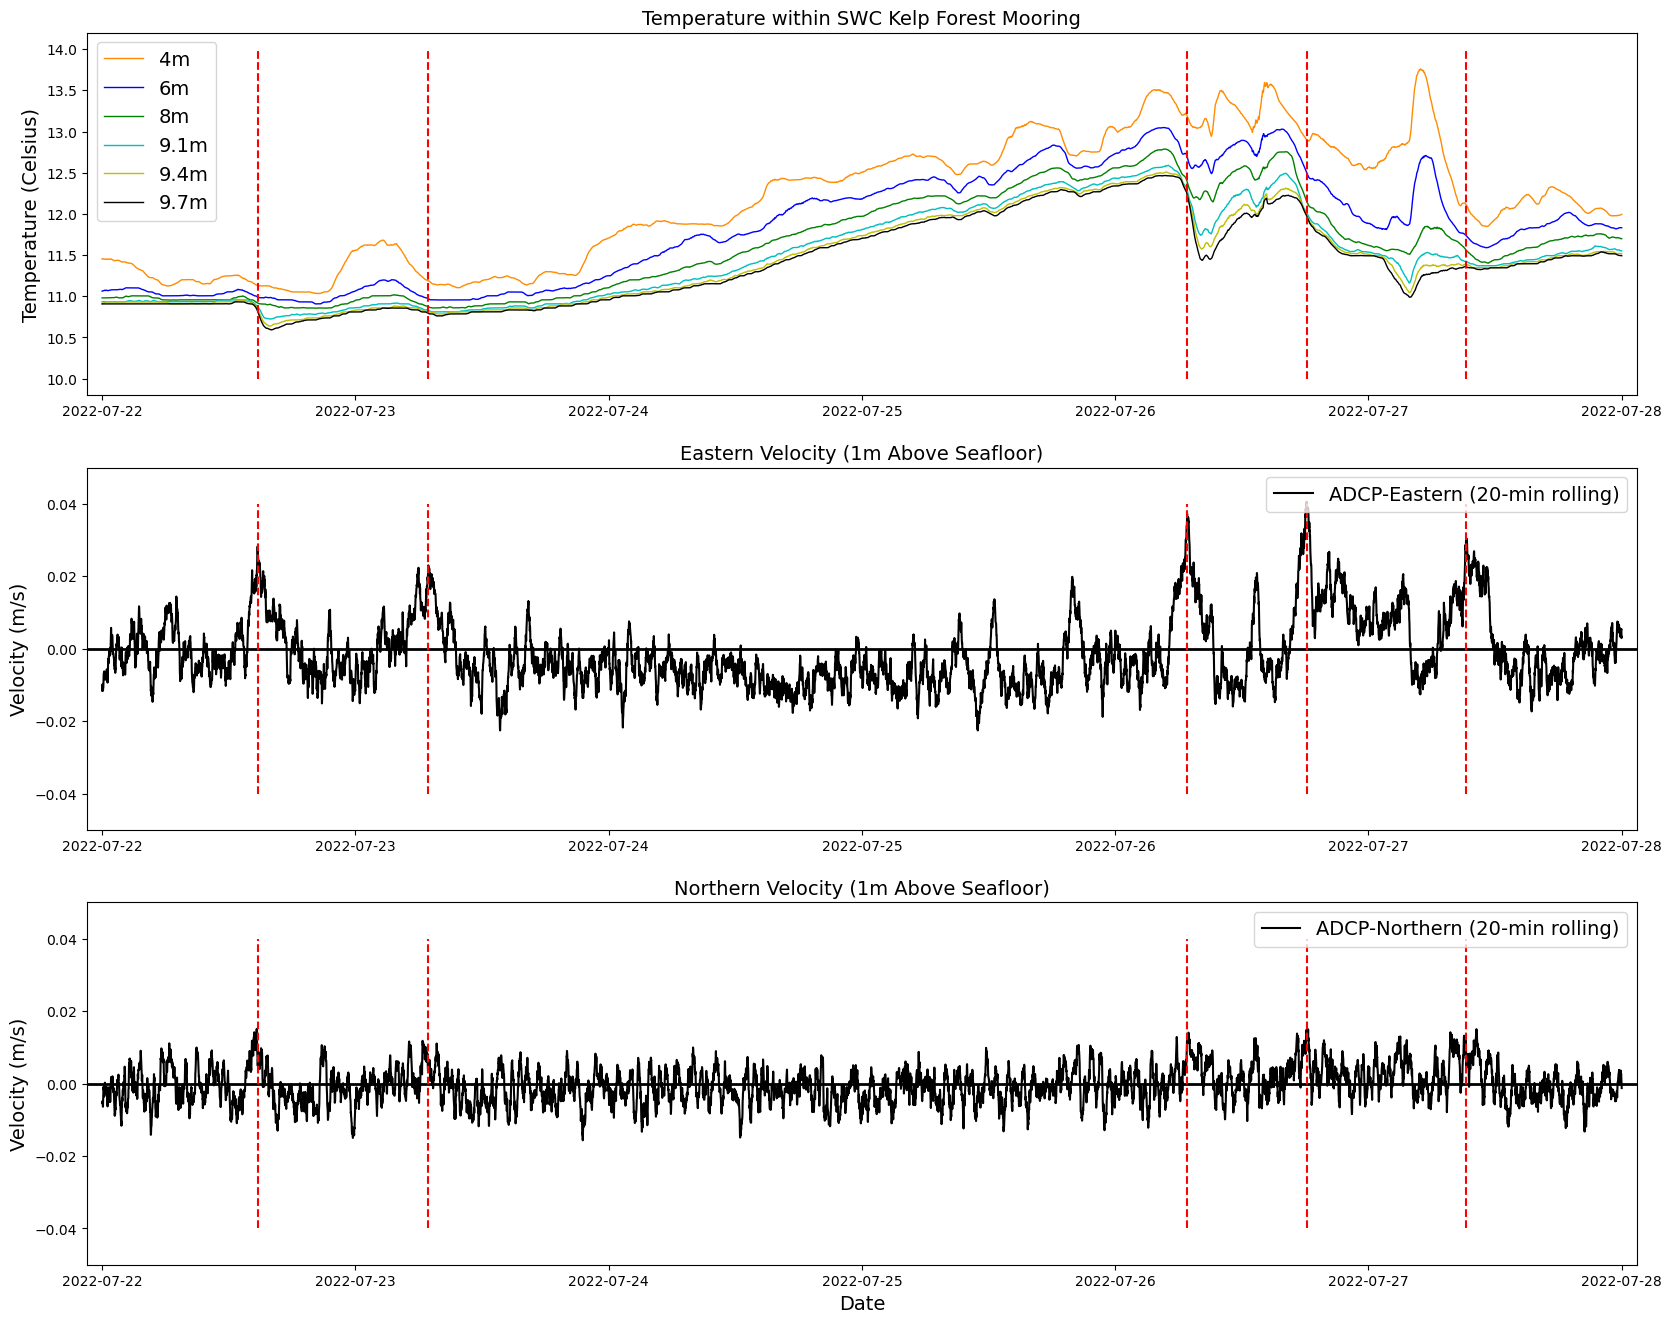

In [99]:
# TEMPERATURE
plt.figure(figsize = (20,16))

plt.subplot(311)
#plt.plot(tempSeg.time, tempSeg.Temperature.isel(depth=0), 'r-', lw = 1)
plt.plot(tempSeg.time, tempSeg.Temperature.isel(depth=1), 'darkorange', lw = 1)
plt.plot(tempSeg.time, tempSeg.Temperature.isel(depth=2), 'b-', lw = 1)
plt.plot(tempSeg.time, tempSeg.Temperature.isel(depth=3), 'g-', lw = 1)
plt.plot(tempSeg.time, tempSeg.Temperature.isel(depth=4), 'c-', lw = 1)
plt.plot(tempSeg.time, tempSeg.Temperature.isel(depth=5), 'y-', lw = 1)
plt.plot(tempSeg.time, tempSeg.Temperature.isel(depth=6), 'k-', lw = 1)

plt.ylabel("Temperature (Celsius)", fontsize=14)
plt.margins(x=.01)
#plt.axvline(x = ceTimes[0].values, c = 'black', lw = 2)
#plt.axvline(x = ceTimes[1].values, c = 'black', lw = 2)
plt.vlines(x = CEs, ymin = 10, ymax = 14, colors='red', linestyles='dashed', label='Cooling Events')
plt.title('Temperature within SWC Kelp Forest Mooring', fontsize=14)
plt.legend(['4m','6m','8m','9.1m', '9.4m', '9.7m'], loc = 'upper left', fontsize=14)
#=================================================================================================
# Eastern Velocity
plt.subplot(312)
#plt.plot(adcpSeg.time, adcpSeg.East.isel(BinDist=1), '.r', label = 'ADCP-Eastern')
plt.plot(adcpSegRoll.time, adcpSegRoll.East,'-k', label = 'ADCP-Eastern (20-min rolling)')
plt.ylim(-.05,.05)
plt.legend(loc = 'upper right', fontsize=14)
plt.axhline(y=0, c='black', lw=2)
plt.vlines(x = CEs, ymin = -.04, ymax = .04, colors='red', linestyles='dashed', label='Cooling Events')
plt.margins(x=.01)
plt.ylabel('Velocity (m/s)', fontsize=14)
plt.title('Eastern Velocity (1m Above Seafloor)', fontsize=14)
#=================================================================================================
# Northern Velocity
plt.subplot(313)
#plt.plot(adcpSeg.time, adcpSeg.North.isel(BinDist=1), '.r', label = 'ADCP-Northern')
plt.plot(adcpSegRoll.time, adcpSegRoll.North,'-k', label = 'ADCP-Northern (20-min rolling)')
plt.ylim(-.05,.05)
plt.legend(loc = 'upper right', fontsize=14)
plt.axhline(y=0, c='black', lw=2)
plt.vlines(x = CEs, ymin = -.04, ymax = .04, colors='red', linestyles='dashed', label='Cooling Events')
plt.margins(x=.01)
plt.ylabel('Velocity (m/s)', fontsize=14)
plt.xlabel('Date', fontsize = 14)
plt.title('Northern Velocity (1m Above Seafloor)', fontsize=14)
#=================================================================================================
# Velocity direction
#plt.subplot(414)
#plt.plot(adcp_10mroll_dep1.time, adcp_10mroll_dep1.Direction,'-k', label = 'ADCP-Velocity Direction (10-min rolling)')
#plt.plot(adv_10m_dep1.time, adv_10m_dep1.CDIR, '.b', label = 'ADV-Velocity Direction (1-min average)')
#plt.legend(loc = 'upper right')
#plt.margins(x=.01)
#plt.ylabel('Direction (Degrees)')
#plt.xlabel('Date')
#plt.title('Velocity direction (1m Above Seafloor)')

plt.savefig('Plots/0722_0728_CEs.png')

## Cooling events
- Cooling event triggered by dramatic drop in temperature and simultaneous dramatic increase in northereastern velocity (0 < velocity < 90)
- Events appear to occur on diurnal to semidiiurnal basis
- Due to orientation of SWC and location of the site, NE velocity is associated with ONSHORE transport
- Visibly looks correlated to tidal cycle

In [ ]:
# Create depth average temperature time series for deployment 1
temp_dep1_da = temp_dep1.Temperature.mean(axis=0)

In [ ]:
# Compare temperature with pressure over time
fig,ax = plt.subplots(figsize = (20, 5))

# make a plot
lns1 = ax.plot(temp_dep1_da.time, temp_dep1_da, 'orange', lw = 2, label='Temperature (DA)')
# set x-axis label
ax.set_xlabel("Datetime", fontsize = 14)
# set y-axis label
ax.set_ylabel("Temperature (Celsius)", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
lns2 = ax2.plot(adv_1m_dep1.time, adv_1m_dep1.Pressure, '.b', lw = 2, label='Pressure')
ax2.set_ylim(8,12)
ax2.set_ylabel("Pressure (Dbar)",fontsize=14)


# Solution for having two legends
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax.legend(loc=1, bbox_to_anchor=(1,.92)) #(leg, labs, loc=0)
plt.axhline(y=359, c='black', lw=2)
plt.axhline(y=280, c='black', lw=2)
plt.title('Depth averaged temperature with pressure', fontsize=14)
plt.legend(bbox_to_anchor=(.99,1))

plt.margins(x=.01, y = .5)
#plt.show()

### Cooling events heavily coincide with rising tide
- Cooling events appear to be driven by tides, pulling colder water from offshore into SWC
- Rate of sea level height appears to be NEGATIVELY correlated with rate of change for temperature

### Zoom in on single event
- Find "good" data
    - adv and adcp data which meets quality controlled standars
    - adv especially needs to be good for future spectral analysis

In [ ]:
test = adv_dep1.where(adv_dep1.Dat_flag < 5)
test = test.dropna(dim = 'time', how="any")
gburst = np.unique(test.Burst_number, return_counts=True)
for i in range(len(np.unique(test.Burst_number))):
    if gburst[1][i]>= 34560:
        print(gburst[0][i])

In [ ]:
# String of good data from burst numbers 108-111
gdat = adv_dep1.where((adv_dep1.Burst_number >= 50) & (adv_dep1.Burst_number <= 80))
gdat = gdat.dropna(dim = 'time', how="any")
temp_dep1_ce = temp_dep1.sel(time=slice(gdat.time[0], gdat.time[-1]))
adv_1m_dep1_ce = adv_1m_dep1.sel(time=slice(gdat.time[0], gdat.time[-1]))
adcp_dep1_ce = adcp_dep1.sel(time=slice(gdat.time[0], gdat.time[-1]))
adcp_10mroll_dep1_ce = adcp_10mroll_dep1.sel(time=slice(gdat.time[0], gdat.time[-1]))

# TEMPERATURE
plt.figure(figsize = (20,16))

plt.subplot(311)
plt.plot(temp_dep1_ce.time, temp_dep1_ce.Temperature.isel(depth=0), 'r-', lw = 1)
plt.plot(temp_dep1_ce.time, temp_dep1_ce.Temperature.isel(depth=1), 'darkorange', lw = 1)
plt.plot(temp_dep1_ce.time, temp_dep1_ce.Temperature.isel(depth=2), 'b-', lw = 1)
plt.plot(temp_dep1_ce.time, temp_dep1_ce.Temperature.isel(depth=3), 'g-', lw = 1)
plt.plot(temp_dep1_ce.time, temp_dep1_ce.Temperature.isel(depth=4), 'c-', lw = 1)
plt.plot(temp_dep1_ce.time, temp_dep1_ce.Temperature.isel(depth=5), 'y-', lw = 1)
plt.plot(temp_dep1_ce.time, temp_dep1_ce.Temperature.isel(depth=6), 'k-', lw = 1)

plt.ylabel("Temperature (Celsius)", fontsize=14)
plt.margins(x=0)
plt.title('Temperature within SWC Kelp Forest Mooring')
plt.legend(['2m','4m','6m','8m','9.1m', '9.4m', '9.7m'], loc = 'upper left')
#=================================================================================================
# Eastern
plt.subplot(312)
plt.plot(adcp_dep1_ce.time, adcp_dep1_ce.East.isel(BinDist=1), '.r', label = 'ADCP-Eastern')
plt.plot(adcp_10mroll_dep1_ce.time, adcp_10mroll_dep1_ce.East, '-k', label = 'ADCP-Eastern (10-min rolling)')
plt.plot(adv_1m_dep1_ce.time, adv_1m_dep1_ce.East, '.b', label = 'ADV-Eastern (1-min average)')
plt.ylim(-.1,.1)
plt.legend(loc = 'upper right')
plt.axhline(y=0, c='black', lw=2)
plt.margins(x=0)
plt.ylabel('Velocity (m/s)')
plt.xlabel('Date')
plt.title('Eastern Velocity (1m Above Seafloor)')
#=================================================================================================
# Current profile
plt.subplot(313)
minvel = -.1 # Limits for the colorbars used on the adcp colorplots
maxvel = .1
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)
plt.title('ADCP Eastern Velocity')
plt.pcolormesh(adcp_dep1_ce.time, adcp_dep1_ce.BinDist, adcp_dep1_ce.East,norm=norm)
plt.colorbar(label='Eastern velocity [m/s]', orientation = 'horizontal', fraction = .1)
plt.ylabel('Depth [MOB]')
plt.margins(x=.01)

### Bursts 53 and 75 are both during cooling event periods
- Next step is to conduct spectral analysis of these bursts

In [ ]:
# THE FOLLOWING CODE IS ADAPTED FROM STEVEN CUNNINGHAM'S MASTERS THESIS (2019)

# Rotate velocity data along the principle axes U and V
theta, major, minor = ts.princax(adv_dep1.East, adv_dep1.North) # theta = angle, major = SD major axis (U), SD minor axis (V)
U, V = ts.rot(adv_dep1.East, adv_dep1.North, -theta)
adv_dep1['U'] = U
adv_dep1['V'] = V

In [ ]:
# Isolate the good bursts
b53 = adv_dep1.where(adv_dep1.Burst_number == 53).dropna(dim = 'time', how="any")
b75 = adv_dep1.where(adv_dep1.Burst_number == 75).dropna(dim = 'time', how="any")

In [ ]:
# Fast Fourier Transform algorithm on major axis 'U'
b53_U_fft = np.fft.fft(b53.U)
b75_U_fft = np.fft.fft(b75.U)

# Calculate spectra and frequency, where delta t is the sample rate
N = 38400 # Length of each burst
delta_t = (1/32) # 32Hz sample frequency
f = np.fft.fftfreq(N, delta_t)
S53 = (2/N) * delta_t * np.abs(b53_U_fft)**2
S75 = (2/N) * delta_t * np.abs(b75_U_fft)**2

In [ ]:
# Smoothing out the spectra
f4_b53, S4_b53 = welch(b53.U, fs=32, nperseg= 2240, window='hanning', detrend='linear')
f4_b53p, S4_b53p = welch(b53.Pressure, fs=32, nperseg= 2240, window='hanning', detrend='linear') # Feddderson uses 70s windows

In [ ]:
fU,SU = periodogram(b53.U, fs=32)
fP,SP = periodogram(b53.Pressure, fs=32)

In [ ]:
plt.figure()
plt.loglog(f4_b53p,S4_b53p)
plt.xlabel('frequency [cps]')
plt.loglog(f4_b53,S4_b53)
plt.ylabel('PSD')
plt.ylim([1e-11,1])